**Exploration des données**  
Dans un premier temps, nous devrons rassembler toutes les images du jeu de données afin de connaître la répartition des étiquettes et de les visualiser pour les adapter ensuite au réseau.

In [88]:
import os
import glob
import numpy as np
from tensorflow.keras.preprocessing import image
import cv2
import matplotlib.pyplot as plt

Cette fonction sera chargée de modifier chacune des images afin que le réseau puisse les traiter.  

Elle redimensionnera chaque image à la taille "pixels".  

Si nous souhaitons modifier la luminosité et le contraste de l'image, nous devrons définir "modification" sur True.  

Nous utiliserons deux ensembles de données différents pour entraîner le réseau:   
- Des images de 16 x 16 sans modifications. 
- Des images de 32 x 32 sans modifications.  
- Des images de 32 x 32 avec des modifications de luminosité et de contraste.

Par la suite, nous analyserons lequel des deux réseaux est le plus performant.

In [89]:
def resize_image(imagen_path, modificacion, pixels):
    # Cargar la imagen utilizando OpenCV
    image = cv2.imread(imagen_path)

    # Convertir la imagen a escala de grises
    image_gris = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    if modificacion:
        alpha = 1.1  # factor de contraste
        beta =  40   # factor de brillo
        image_gris = cv2.convertScaleAbs(image_gris, alpha=alpha, beta=beta)

    imagen_final = cv2.resize(image_gris, (pixels, pixels), interpolation=cv2.INTER_AREA)

    return imagen_final


Cette autre sera utilisée pour enregistrer les images traitées dans:  
- data/images_16x16  
- data/images_32x32
- data/images_32x32_mod
  
Avec le même format d'image afin que l'information ne soit pas perdue.

In [90]:
def save_images_from_array(images_array, etiquettes, folder_path):
    """
    Sauvegarde toutes les images d'un numpy array dans un dossier donné, 
    en les classant et en les nommant selon leurs étiquettes.

    Args:
        images_array (np.array): Tableau d'images à sauvegarder.
        etiquettes (list): Liste des étiquettes correspondant aux images.
        folder_path (str): Chemin du dossier où les images seront sauvegardées.
    """
    # Vérifier que le dossier parent existe
    os.makedirs(folder_path, exist_ok=True)
    
    # Dictionnaire pour compter les images par étiquette
    label_counters = {}

    # Parcourir les images et leurs étiquettes
    for i, (img, label) in enumerate(zip(images_array, etiquettes)):
        # Assurer un compteur pour chaque étiquette
        if label not in label_counters:
            label_counters[label] = 0
        label_counters[label] += 1

        # Nommer les fichiers selon leur étiquette et numéro
        file_name = f"{label}_{label_counters[label]}.jpeg"
        
        # Chemin complet pour sauvegarder l'image
        file_path = os.path.join(folder_path, file_name)
        
        # Sauvegarder l'image à l'emplacement spécifié
        cv2.imwrite(file_path, img)

    print(f"{len(images_array)} images ont été sauvegardées dans le dossier : {folder_path}")

Nous collecterons les données de toutes les images dans les dossiers 'train' et 'test', car nous ajusterons nous-mêmes la proportion entre train et test, en fonction du nombre de splits effectués lors de la validation croisée.


In [47]:
def load_data(path ,modificacion, pixels):
    name_classes = ['NORMAL', 'PNEUMONIA_BACTERIA', 'PNEUMONIA_VIRUS']
    X, y = [], []

    # Listar las carpetas principales
    base_dirs = [path + r'\test', path + r'\train']

    for base_dir in base_dirs:
        for class_name in ['NORMAL', 'PNEUMONIA']:
            path = rf'{base_dir}\{class_name}\*.jpeg'
            for filename in glob.glob(path):
                im = resize_image(filename, modificacion, pixels)
                X.append(image.img_to_array(im))
                
                # Determinar la clase en función del nombre del archivo
                if class_name == 'NORMAL':
                    y.append(0)  # Clase 0: NORMAL
                elif 'bacteria' in filename.lower():
                    y.append(1)  # Clase 1: PNEUMONIA_BACTERIA
                elif 'virus' in filename.lower():
                    y.append(2)  # Clase 2: PNEUMONIA_VIRUS

    input_shape = (pixels, pixels, 1)
    return np.array(X), np.array(y), input_shape

path=r"..\data\external\chest_xray"

modificacion_16x16 = False
pixels_16x16 = 16

images_16x16 ,etiquetes_16x16 ,_ = load_data(path, modificacion_16x16, pixels_16x16)

path_save_16x16=r"..\data\processed\images_16x16"
save_images_from_array(images_16x16,etiquetes_16x16,path_save_16x16)

modificacion_32x32 = False
pixels_32x32 = 32

images_32x32 ,etiquetes_32x32 ,_ = load_data(path, modificacion_32x32, pixels_32x32)

path_save_32x32=r"..\data\processed\images_32x32"
save_images_from_array(images_32x32,etiquetes_32x32,path_save_32x32) 

modificacion_32x32_mod = True
pixels_32x32_mod = 32

images_32x32_mod ,etiquetes_32x32_mod ,_ = load_data(path, modificacion_32x32_mod, pixels_32x32_mod)

path_save_32x32_mod=r"..\data\processed\images_32x32_mod"
save_images_from_array(images_32x32_mod,etiquetes_32x32_mod,path_save_32x32_mod)



5832 images ont été sauvegardées dans le dossier : ..\data\processed\images_16x16
5832 images ont été sauvegardées dans le dossier : ..\data\processed\images_32x32
5832 images ont été sauvegardées dans le dossier : ..\data\processed\images_32x32_mod


Voyons comment se distribuent les données.

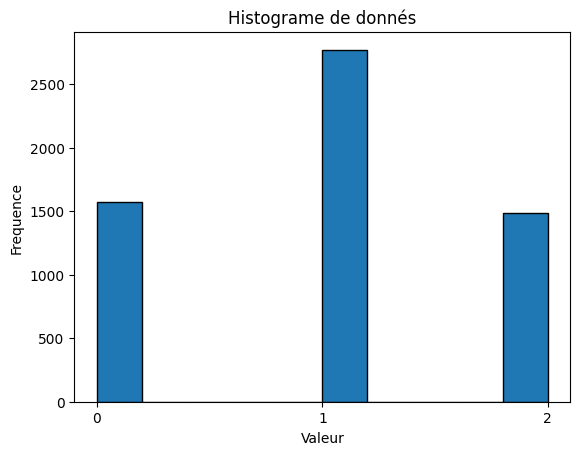

In [36]:
# Crear el histograma
plt.hist(etiquetes_16x16, edgecolor='black')
# Añadir título y etiquetas
plt.title("Histograme de donnés")
plt.xlabel('Valeur')
plt.ylabel('Frequence')

plt.xticks([0, 1, 2])

# Mostrar el histograma
plt.show()

In [38]:
# Obtener los valores únicos y sus conteos
unique_elements, counts = np.unique(etiquetes_16x16, return_counts=True)

print(f'NORMAL: label: {unique_elements[0]} | Frequence: {counts[0]}\n') 
print(f'PNEUMONIA_BACTERIA: label: {unique_elements[1]} | Frequence: {counts[1]}') 
print(f'PNEUMONIA_VIRUS: label: {unique_elements[2]} | Frequence: {counts[2]}\n') 

print(f'Total PNEUMONIA: label: {unique_elements[1]},{unique_elements[2]} | Frequence: {counts[1]+counts[2]}') 


NORMAL: label: 0 | Frequence: 1575

PNEUMONIA_BACTERIA: label: 1 | Frequence: 2772
PNEUMONIA_VIRUS: label: 2 | Frequence: 1485

Total PNEUMONIA: label: 1,2 | Frequence: 4257


Il y a un déséquilibre dans les données:  
**Normal : 27 %**  
**PNEUMONIA : 73 %**    

Comme nous pouvons le constater, cet écart n'est pas très important, nous conserverons donc cette proportion.

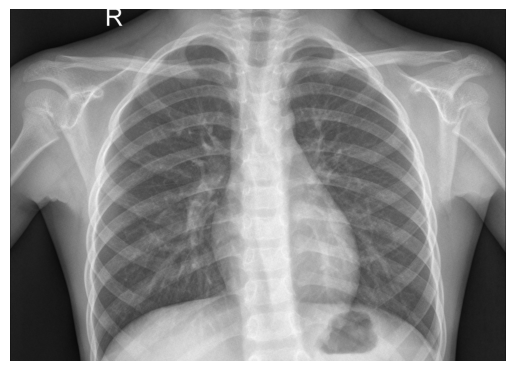

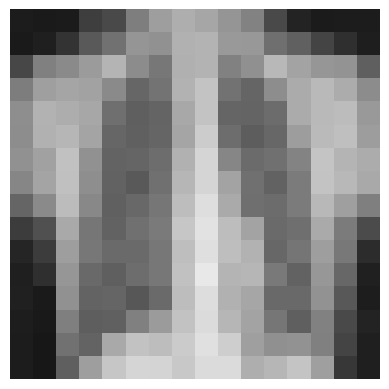

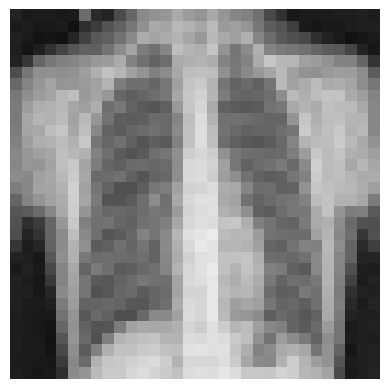

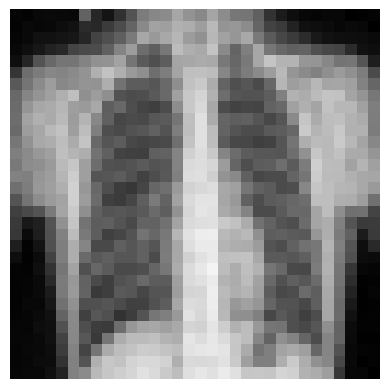

In [ ]:
image = r"..\data\external\chest_xray\test\NORMAL\IM-0001-0001.jpeg"
image_16x16 = r"..\data\processed\images_16x16\0_1.jpeg"
image_32x23 = r"..\data\processed\images_32x32\0_1.jpeg"
image_32x32_mod = r"..\data\processed\images_32x32_mod\0_1.jpeg"

normal = cv2.imread(image)

plt.imshow(normal)
plt.axis('off')  # Opcional: quita los ejes de la imagen
plt.show()

normal_16x16 = cv2.imread(image_16x16)

plt.imshow(normal_16x16)
plt.axis('off')  # Opcional: quita los ejes de la imagen
plt.show()

normal_32x23 = cv2.imread(image_32x23)

plt.imshow(normal_32x23)
plt.axis('off')  # Opcional: quita los ejes de la imagen
plt.show()

normal_32x32_mod = cv2.imread(image_32x32_mod)

plt.imshow(normal_32x32_mod)
plt.axis('off')  # Opcional: quita los ejes de la imagen
plt.show()

Voici la différence entre l'image originale et celles qui seront traitées par les modèles.